<center><h1>1-cd: Convolutional Neural Networks (ConvNets)</h1></center>

In [2]:
import argparse
import os
import time

import torch
import torch.nn as nn
import torch.nn.parallel
import torch.backends.cudnn as cudnn
import torch.optim
import torch.utils.data
import torchvision.transforms as transforms
import torchvision.datasets as datasets

from utils import *

PRINT_INTERVAL = 200
PATH="datasets"

'''
IMPORTANT: to run torch on cuda (gpu), use this command instead to install it:
python -m pip install torch==2.2.0+cu118 torchvision torchaudio --index-url https://download.pytorch.org/whl/cu118
'''

'\nIMPORTANT: to run torch on cuda (gpu), use this command instead to install it:\npython -m pip install torch==2.2.0+cu118 torchvision torchaudio --index-url https://download.pytorch.org/whl/cu118\n'

In [3]:
class ConvNet(nn.Module):
    """
    This class defines the structure of the neural network
    """

    def __init__(self):
        super(ConvNet, self).__init__()
        # We first define the convolution and pooling layers as a features extractor
        self.features = nn.Sequential(
            nn.Conv2d(1, 6, (5, 5), stride=1, padding=2),
            nn.Tanh(),
            nn.MaxPool2d((2, 2), stride=2, padding=0),
            nn.Conv2d(6, 16, (5, 5), stride=1, padding=0),
            nn.Tanh(),
            nn.MaxPool2d((2, 2), stride=2, padding=0),
        )
        # We then define fully connected layers as a classifier
        self.classifier = nn.Sequential(
            nn.Linear(400, 120),
            nn.Tanh(),
            nn.Linear(120, 84),
            nn.Tanh(),
            nn.Linear(84, 10)
            # Reminder: The softmax is included in the loss, do not put it here
        )

    # Method called when we apply the network to an input batch
    def forward(self, input):
        bsize = input.size(0) # batch size
        output = self.features(input) # output of the conv layers
        output = output.view(bsize, -1) # we flatten the 2D feature maps into one 1D vector for each input
        output = self.classifier(output) # we compute the output of the fc layers
        return output



def get_dataset(batch_size, cuda=False):
    """
    This function loads the dataset and performs transformations on each
    image (listed in `transform = ...`).
    """
    train_dataset = datasets.MNIST(PATH, train=True, download=True,
        transform=transforms.Compose([
            transforms.ToTensor()
        ]))
    val_dataset = datasets.MNIST(PATH, train=False, download=True,
        transform=transforms.Compose([
            transforms.ToTensor()
        ]))

    train_loader = torch.utils.data.DataLoader(train_dataset,
                        batch_size=batch_size, shuffle=True, pin_memory=cuda, num_workers=2)
    val_loader = torch.utils.data.DataLoader(val_dataset,
                        batch_size=batch_size, shuffle=False, pin_memory=cuda, num_workers=2)

    return train_loader, val_loader



def epoch(data, model, criterion, optimizer=None, cuda=False):
    """
    Make a pass (called epoch in English) on the data `data` with the
     model `model`. Evaluates `criterion` as loss.
     If `optimizer` is given, perform a training epoch using
     the given optimizer, otherwise, perform an evaluation epoch (no backward)
     of the model.
    """

    # indicates whether the model is in eval or train mode (some layers behave differently in train and eval)
    model.eval() if optimizer is None else model.train()

    # objects to store metric averages
    avg_loss = AverageMeter()
    avg_top1_acc = AverageMeter()
    avg_top5_acc = AverageMeter()
    avg_batch_time = AverageMeter()
    global loss_plot

    # we iterate on the batches
    tic = time.time()
    for i, (input, target) in enumerate(data):

        if cuda: # only with GPU, and not with CPU
            input = input.cuda()
            target = target.cuda()

        # forward
        output = model(input)
        loss = criterion(output, target)

        # backward if we are training
        if optimizer:
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        # compute metrics
        prec1, prec5 = accuracy(output, target, topk=(1, 5))
        batch_time = time.time() - tic
        tic = time.time()

        # update
        avg_loss.update(loss.item())
        avg_top1_acc.update(prec1.item())
        avg_top5_acc.update(prec5.item())
        avg_batch_time.update(batch_time)
        if optimizer:
            loss_plot.update(avg_loss.val)
        # print info
        if i % PRINT_INTERVAL == 0:
            print('[{0:s} Batch {1:03d}/{2:03d}]\t'
                  'Time {batch_time.val:.3f}s ({batch_time.avg:.3f}s)\t'
                  'Loss {loss.val:.4f} ({loss.avg:.4f})\t'
                  'Prec@1 {top1.val:5.1f} ({top1.avg:5.1f})\t'
                  'Prec@5 {top5.val:5.1f} ({top5.avg:5.1f})'.format(
                   "EVAL" if optimizer is None else "TRAIN", i, len(data), batch_time=avg_batch_time, loss=avg_loss,
                   top1=avg_top1_acc, top5=avg_top5_acc))
            if optimizer:
                loss_plot.plot()

    # Print summary
    print('\n===============> Total time {batch_time:d}s\t'
          'Avg loss {loss.avg:.4f}\t'
          'Avg Prec@1 {top1.avg:5.2f} %\t'
          'Avg Prec@5 {top5.avg:5.2f} %\n'.format(
           batch_time=int(avg_batch_time.sum), loss=avg_loss,
           top1=avg_top1_acc, top5=avg_top5_acc))

    return avg_top1_acc, avg_top5_acc, avg_loss


def main(batch_size=128, lr=0.1, epochs=5, cuda=False):

    # ex :
    #   {"batch_size": 128, "epochs": 5, "lr": 0.1}

    # define model, loss, optim
    model = ConvNet()
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.SGD(model.parameters(), lr)

    if cuda: # only with GPU, and not with CPU
        cudnn.benchmark = True
        model = model.cuda()
        criterion = criterion.cuda()

    # Get the data
    train, test = get_dataset(batch_size, cuda)

    # init plots
    plot = AccLossPlot()
    global loss_plot
    loss_plot = TrainLossPlot()

    # We iterate on the epochs
    for i in range(epochs):
        print("=================\n=== EPOCH "+str(i+1)+" =====\n=================\n")
        # Train phase
        top1_acc, avg_top5_acc, loss = epoch(train, model, criterion, optimizer, cuda)
        # Test phase
        top1_acc_test, top5_acc_test, loss_test = epoch(test, model, criterion, cuda=cuda)
        # plot
        plot.update(loss.avg, loss_test.avg, top1_acc.avg, top1_acc_test.avg)


100.0%
100.0%
100.0%
100.0%


=== EPOCH 1 =====

[TRAIN Batch 000/469]	Time 5.591s (5.591s)	Loss 2.3108 (2.3108)	Prec@1   8.6 (  8.6)	Prec@5  47.7 ( 47.7)


<Figure size 640x480 with 0 Axes>

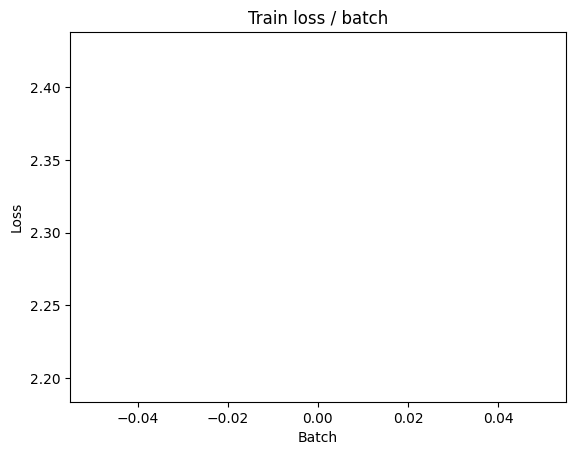

[TRAIN Batch 200/469]	Time 0.011s (0.043s)	Loss 0.2027 (1.2256)	Prec@1  98.4 ( 67.3)	Prec@5 100.0 ( 91.0)


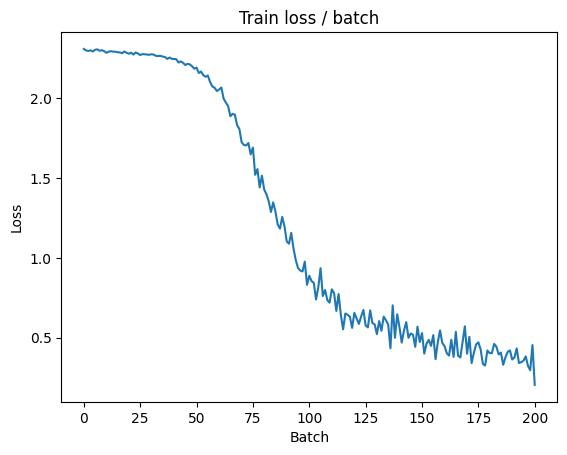

[TRAIN Batch 400/469]	Time 0.013s (0.029s)	Loss 0.1431 (0.7437)	Prec@1  96.9 ( 79.9)	Prec@5 100.0 ( 95.3)


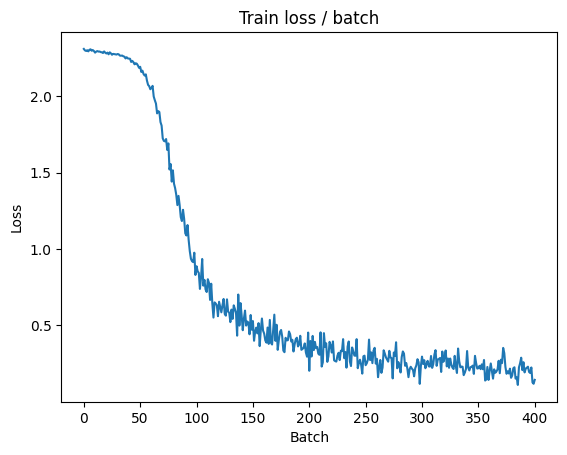


===============> Total time 12s	Avg loss 0.6597	Avg Prec@1 82.14 %	Avg Prec@5 95.96 %

[EVAL Batch 000/079]	Time 5.236s (5.236s)	Loss 0.0863 (0.0863)	Prec@1  99.2 ( 99.2)	Prec@5 100.0 (100.0)

===============> Total time 6s	Avg loss 0.1460	Avg Prec@1 95.59 %	Avg Prec@5 99.96 %



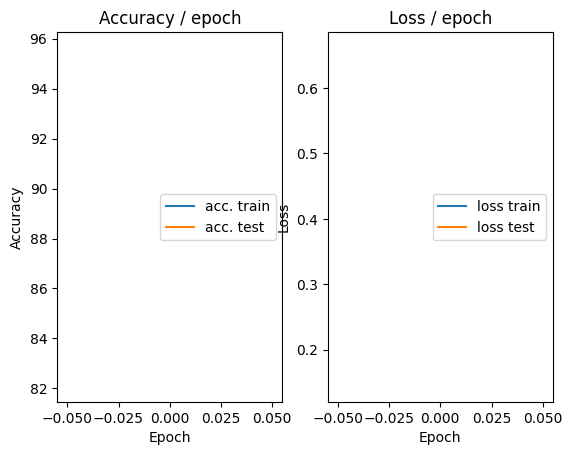

=== EPOCH 2 =====

[TRAIN Batch 000/469]	Time 5.027s (5.027s)	Loss 0.1661 (0.1661)	Prec@1  94.5 ( 94.5)	Prec@5 100.0 (100.0)


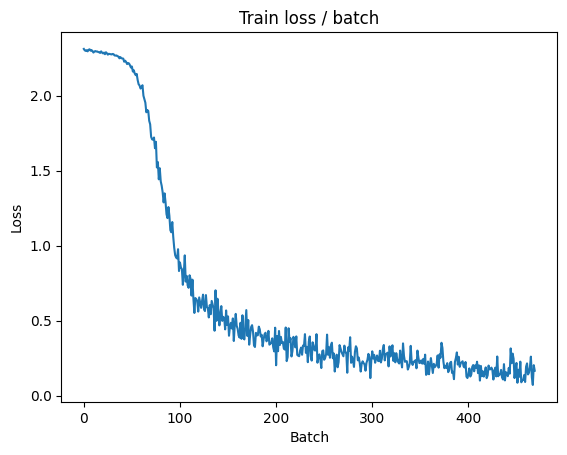

[TRAIN Batch 200/469]	Time 0.014s (0.040s)	Loss 0.1622 (0.1436)	Prec@1  95.3 ( 95.8)	Prec@5 100.0 ( 99.9)


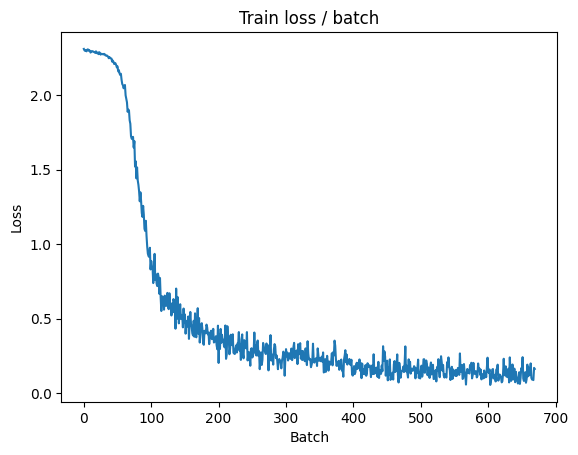

[TRAIN Batch 400/469]	Time 0.014s (0.027s)	Loss 0.0778 (0.1258)	Prec@1  97.7 ( 96.3)	Prec@5 100.0 ( 99.9)


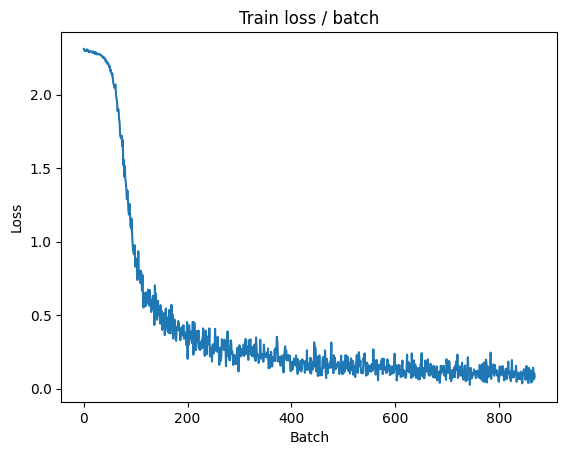


===============> Total time 12s	Avg loss 0.1217	Avg Prec@1 96.39 %	Avg Prec@5 99.90 %

[EVAL Batch 000/079]	Time 5.962s (5.962s)	Loss 0.0275 (0.0275)	Prec@1 100.0 (100.0)	Prec@5 100.0 (100.0)

===============> Total time 7s	Avg loss 0.0803	Avg Prec@1 97.56 %	Avg Prec@5 99.98 %



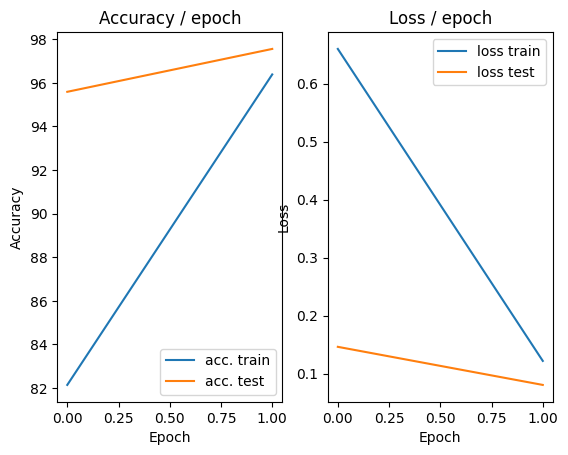

=== EPOCH 3 =====

[TRAIN Batch 000/469]	Time 5.956s (5.956s)	Loss 0.1101 (0.1101)	Prec@1  96.9 ( 96.9)	Prec@5  99.2 ( 99.2)


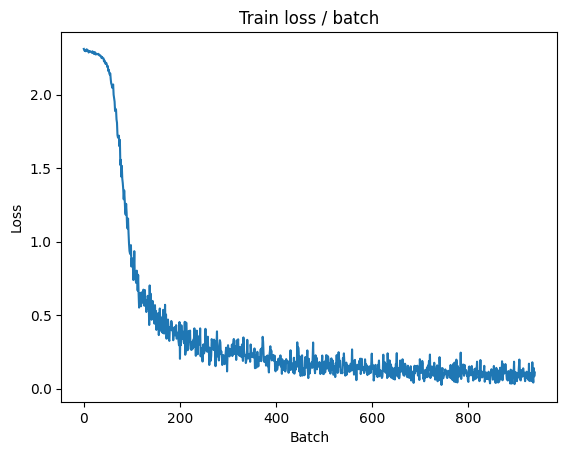

[TRAIN Batch 200/469]	Time 0.017s (0.049s)	Loss 0.0349 (0.0859)	Prec@1  99.2 ( 97.5)	Prec@5 100.0 ( 99.9)


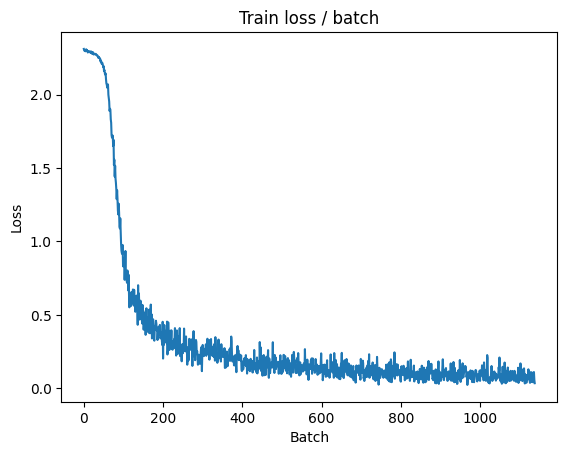

[TRAIN Batch 400/469]	Time 0.021s (0.034s)	Loss 0.1154 (0.0827)	Prec@1  97.7 ( 97.5)	Prec@5 100.0 ( 99.9)


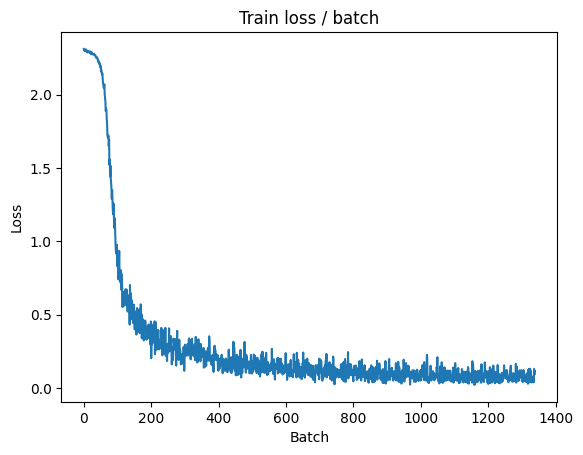


===============> Total time 15s	Avg loss 0.0810	Avg Prec@1 97.60 %	Avg Prec@5 99.93 %

[EVAL Batch 000/079]	Time 6.783s (6.783s)	Loss 0.0247 (0.0247)	Prec@1 100.0 (100.0)	Prec@5 100.0 (100.0)

===============> Total time 8s	Avg loss 0.0638	Avg Prec@1 97.94 %	Avg Prec@5 100.00 %



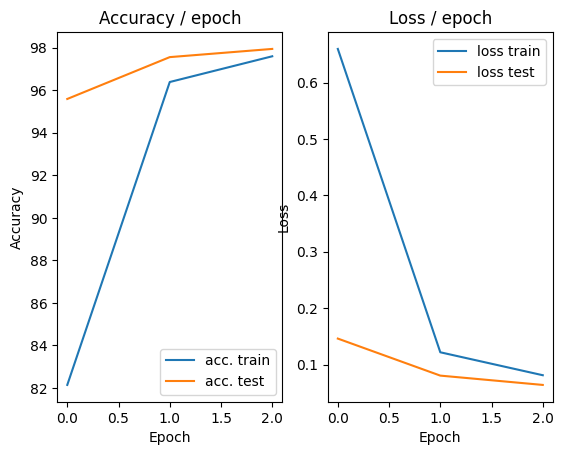

=== EPOCH 4 =====

[TRAIN Batch 000/469]	Time 6.789s (6.789s)	Loss 0.0715 (0.0715)	Prec@1  98.4 ( 98.4)	Prec@5 100.0 (100.0)


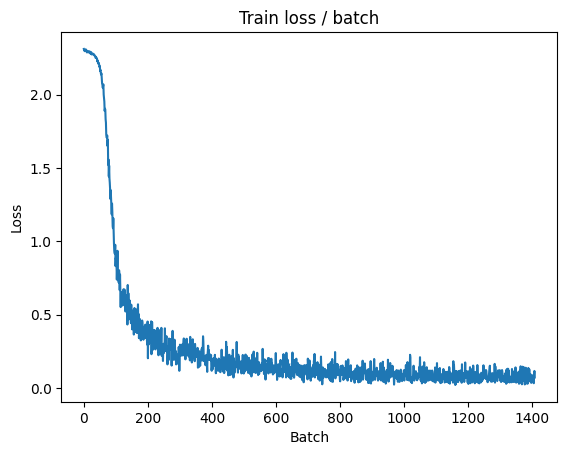

[TRAIN Batch 200/469]	Time 0.015s (0.055s)	Loss 0.0630 (0.0672)	Prec@1  98.4 ( 98.1)	Prec@5 100.0 ( 99.9)


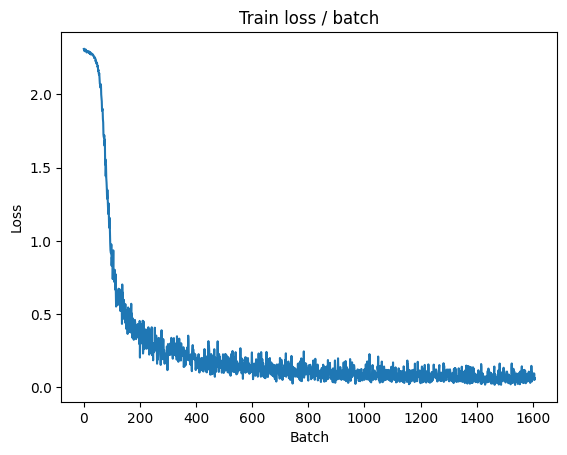

[TRAIN Batch 400/469]	Time 0.033s (0.037s)	Loss 0.1153 (0.0641)	Prec@1  96.1 ( 98.1)	Prec@5  99.2 (100.0)


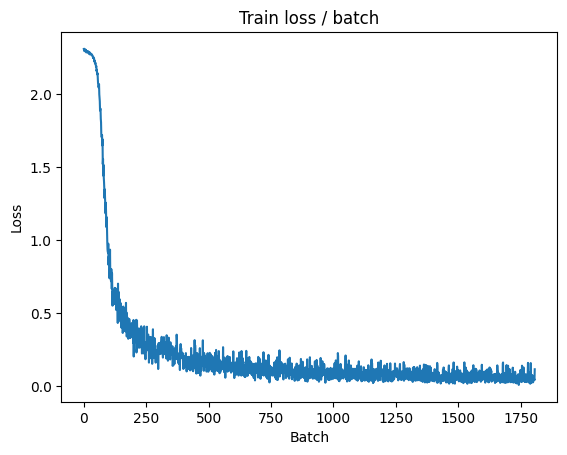


===============> Total time 16s	Avg loss 0.0632	Avg Prec@1 98.12 %	Avg Prec@5 99.96 %

[EVAL Batch 000/079]	Time 5.886s (5.886s)	Loss 0.0191 (0.0191)	Prec@1  99.2 ( 99.2)	Prec@5 100.0 (100.0)

===============> Total time 7s	Avg loss 0.0532	Avg Prec@1 98.38 %	Avg Prec@5 100.00 %



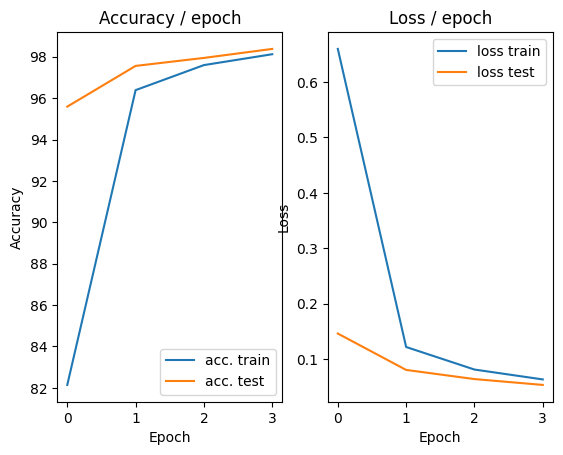

=== EPOCH 5 =====

[TRAIN Batch 000/469]	Time 6.060s (6.060s)	Loss 0.0591 (0.0591)	Prec@1  98.4 ( 98.4)	Prec@5 100.0 (100.0)


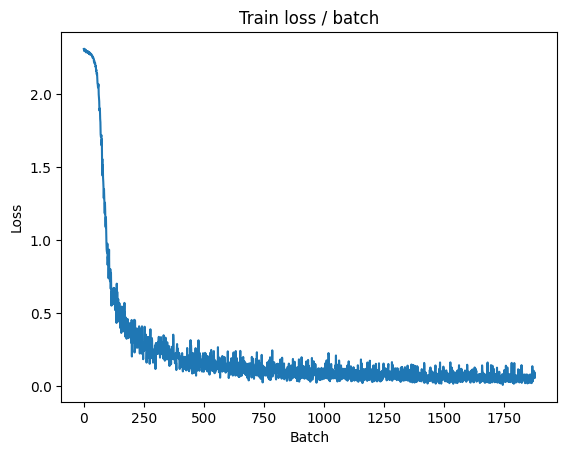

[TRAIN Batch 200/469]	Time 0.017s (0.050s)	Loss 0.1454 (0.0540)	Prec@1  97.7 ( 98.5)	Prec@5  99.2 (100.0)


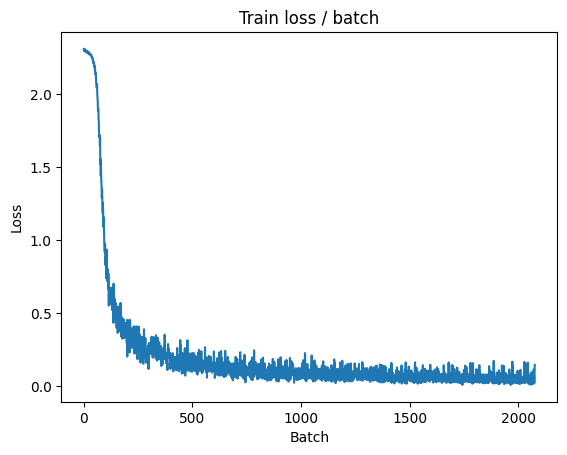

[TRAIN Batch 400/469]	Time 0.019s (0.035s)	Loss 0.0466 (0.0529)	Prec@1  98.4 ( 98.5)	Prec@5 100.0 (100.0)


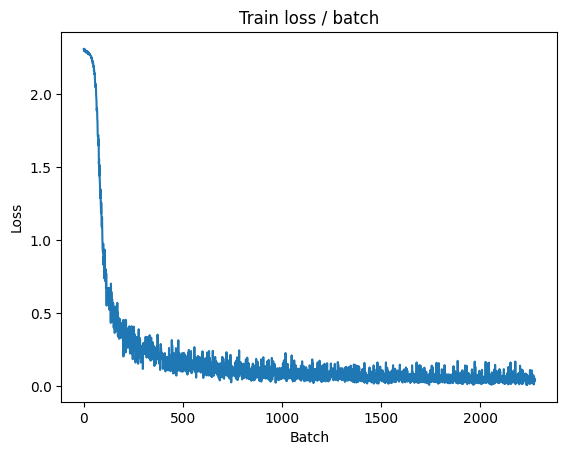


===============> Total time 15s	Avg loss 0.0529	Avg Prec@1 98.45 %	Avg Prec@5 99.98 %

[EVAL Batch 000/079]	Time 6.389s (6.389s)	Loss 0.0250 (0.0250)	Prec@1  99.2 ( 99.2)	Prec@5 100.0 (100.0)

===============> Total time 7s	Avg loss 0.0472	Avg Prec@1 98.50 %	Avg Prec@5 100.00 %



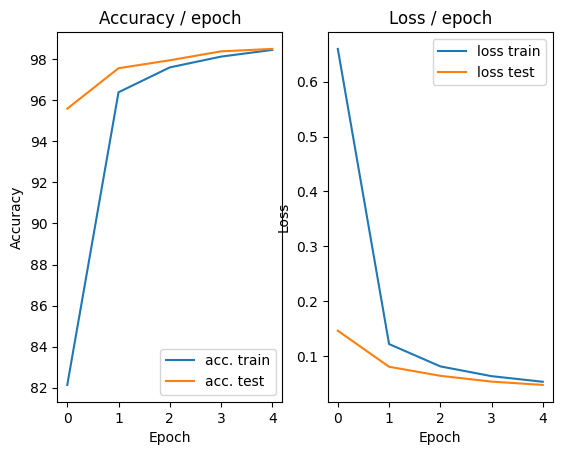

In [5]:
main(128, 0.1, cuda=False) # change cuda if its available